# Kevin Martin CIS700 - Monday @ 8:00pm EST

Final

# 0. Data Setup

Dataset found here:
https://www.kaggle.com/georgezakharov/historical-data-on-the-trading-of-cryptocurrencies/kernels

As a quick summary, I have first imported all the modules I have been using/testing. As I've gone through, I've had to remove less effective approaches, so not all imported functions are used. Next, I loaded my dataset as a pandas dataframe, removed the completely irrelevant columns, and deleted missing (NaN) values. After Assessment 1, I noted that the major coins did not have much missing data, so removing the missing values kept their records intact. The lesser/more obscure coins were mostly affected, which is fine for this purpose.

In [8]:
#python libararies
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from numpy import nan
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,AveragePooling1D,Reshape
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import xgboost as xgb
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from statistics import mode

#load my dataset as a pandas dataframe
path = '/home/kebin/Syracuse/CIS700_All/Assignment1/crypto.csv'
df =  pd.read_csv(path, sep=',') 

#clean dataset by dropping unnecessary columns, missing values, and adding a binary 'IsBit' flag
del_col_list = ['site_url', 'github_url', 'platform_name', 'industry_name', 'crypto_type']
df.drop(del_col_list, axis=1, inplace=True)
df.dropna(inplace=True)
df['IsBit'] = np.where(df['ticker']=='BTC',1,0)
print(df.shape)
df.info()

FileNotFoundError: [Errno 2] File /home/kebin/Syracuse/CIS700_All/Assignment1/crypto.csv does not exist: '/home/kebin/Syracuse/CIS700_All/Assignment1/crypto.csv'

In [2]:
# I will be focuing bitcoin, and using the btc_data data frame
btc_data = df[df['ticker']=='BTC']
print(btc_data.shape[0])

1554


In [3]:
# driver functions
time_data = btc_data['price_usd']
total = df[df.ticker=='BTC'].shape[0]
test = int(round(total * .25))
train = total - test
buff = 80

prev_values = time_data.iloc[:1200]
y_train3 = time_data[buff:train]
y_test3 = time_data[train:]
X_train3 = pd.DataFrame([list(time_data[i:i+buff]) for i in range(train - buff)],
                       columns=range(buff,0,-1),index=y_train3.index)
X_test3 = pd.DataFrame([list(time_data[i:i+buff]) for i in range(train - buff,total - buff)],
                       columns=range(buff,0,-1),index=y_test3.index)
    
def plot_pred(pred,title):
    plt.figure(figsize=(17,5))
    plt.plot(prev_values,label='Train')
    plt.plot(y_test3,label='Actual')
    plt.plot(pred,label='Predicted')
    plt.ylabel("Stock prices")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.show()

def evaluate(model):
    out_mod = model.fit(X_train3, y_train3)
    y_pred_mod = model.predict(X_test3)
    print('Accuracy: ', out_mod.score(X_test3, y_test3))
    print('MSE: ',"%.2f" % mse(y_pred_mod,y_test3))
    print('MAE: ',"%.2f" % mae(y_pred_mod,y_test3))
    # return out_mod
    return y_pred_mod

# 1. Subsampling

In order to best train my models, I will be employing a couple methods to end up at an ensemble approach. I'll be using bagging as a hold out approach and allowing my models to only see a certain percent of the available records to train on. Then I will test on the remaining portion. As my target variable is daily price, I will be using regression algorithms. The training data will be the number of days, so for example if there were 1,200 available days, I may choose to train on 75%, which would be 800 days, and test on the remaing 25%, or 400 days. 

In an effort to come up with the most efficient model, I will test multiple approaches (the bagging portion). I will use a three linear regression algorithms and three different time periods to train on. Thus I will have nine different models. After comparing and contrasting the effectiveness of each, I will finish by combining them using a couple of different ensemble technqiues.

Accuracy:  0.9443899927620576
MSE:  222948.60
MAE:  338.34


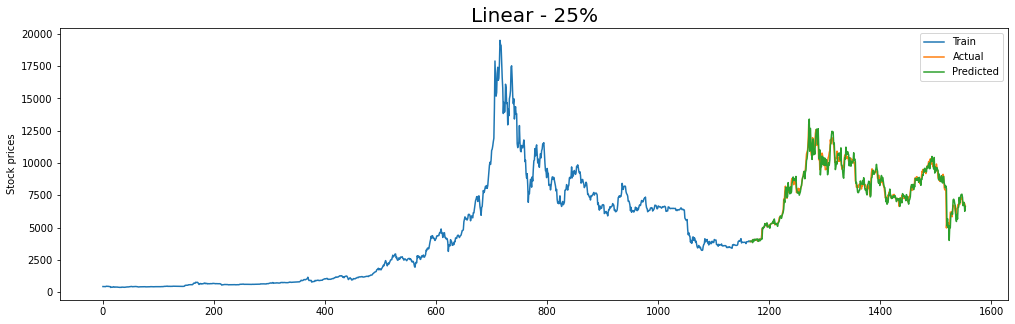

In [4]:
regl = linear_model.LinearRegression()
regl_train = evaluate(regl)
regl_train_shift = pd.Series(regl_train[:],index=y_test3.index)
plot_pred(regl_train_shift,"Linear - 25%")

Accuracy:  0.9443901269229338
MSE:  222948.06
MAE:  338.34


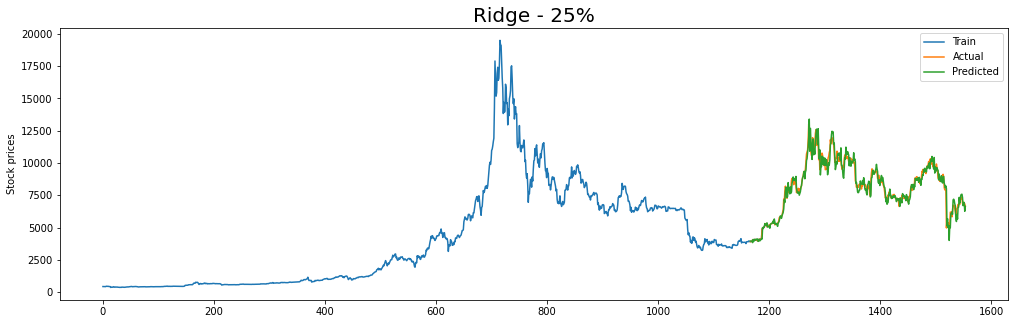

In [5]:
regr = linear_model.Ridge(alpha=200)
regr_train = evaluate(regr)
regr_train_shift = pd.Series(regr_train[:],index=y_test3.index)
plot_pred(regr_train_shift,"Ridge - 25%")

Accuracy:  0.9580139717438815
MSE:  168328.09
MAE:  283.22


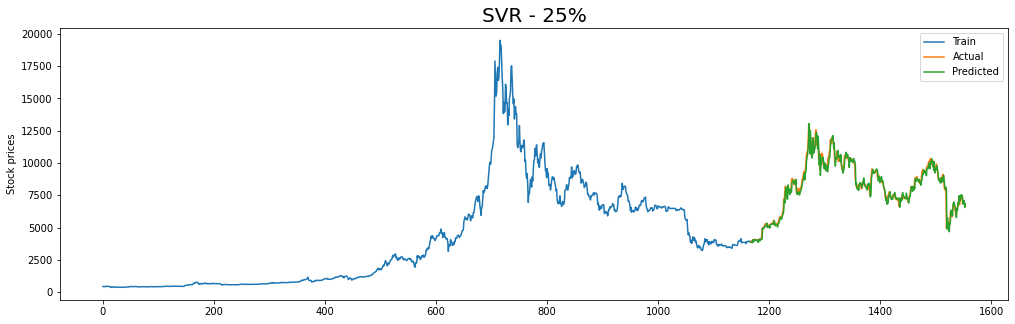

CPU times: user 438 ms, sys: 714 ms, total: 1.15 s
Wall time: 315 ms


In [6]:
%%time
reg_svr = make_pipeline(LinearSVR())
regs_train = evaluate(reg_svr)
regs_train_shift = pd.Series(regs_train[:],index=y_test3.index)
plot_pred(regs_train_shift,"SVR - 25%")

In [7]:
# new driver function for training sets 2 and 3
def data_gen(day_frac):
    tmp_data = df[df['ticker']=='BTC']
    price_data = tmp_data['price_usd']
    total = df[df.ticker=='BTC'].shape[0]
    test = int(round(total * day_frac))
    train = total - test
    buff = 80

    prev = price_data.iloc[:1200]
    y_train = price_data[buff:train]
    y_test = price_data[train:]
    x_train = pd.DataFrame([list(price_data[i:i+buff]) for i in range(train - buff)],
                           columns=range(buff,0,-1),index=y_train.index)
    x_test = pd.DataFrame([list(price_data[i:i+buff]) for i in range(train - buff,total - buff)],
                           columns=range(buff,0,-1),index=y_test.index)
    
    return x_train, y_train, x_test, y_test, prev
    

def evaluate_tick(model, xtrain, ytrain, xtest, ytest):
    out_mod = model.fit(xtrain, ytrain) 
    y_pred_mod2 = model.predict(xtest) 
    print('Accuracy: ', out_mod.score(xtest, ytest))
    print('MSE: ',"%.2f" % mse(y_pred_mod2,ytest))
    # return out_mod
    return y_pred_mod2

def plot_pred_tick(pred,title, test, pre):
    plt.figure(figsize=(17,5))
    plt.plot(pre,label='Train')
    plt.plot(test,label='Actual') #y_test3
    plt.plot(pred,label='Predicted')
    plt.ylabel("Stock prices")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.show()

Accuracy:  0.9710417313760805
MSE:  174824.90


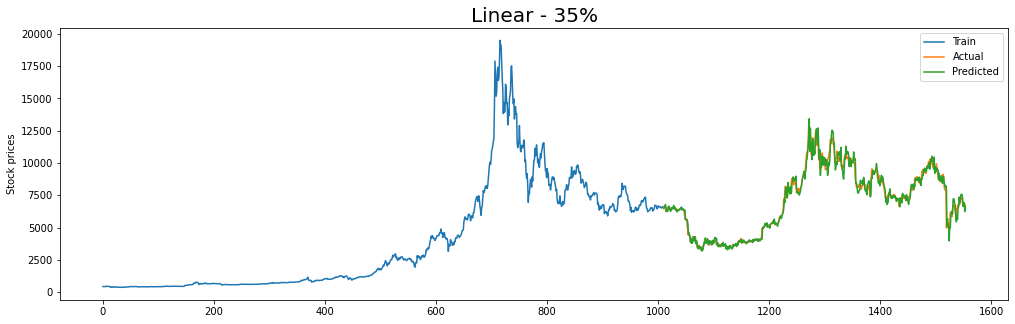

In [8]:
# for model series 2, 35% training
# linear
train_days2 = .35
trainx2_l, trainy2_l, testx2_l, testy2_l, prev_input2_l = data_gen(train_days2)
regl_train2 = evaluate_tick(regl, trainx2_l, trainy2_l, testx2_l, testy2_l)
regl_train2_shift = pd.Series(regl_train2[:],index=testy2_l.index)
plot_pred_tick(regl_train2_shift, 'Linear - 35%', testy2_l, prev_input2_l)

Accuracy:  0.9710418176947688
MSE:  174824.38


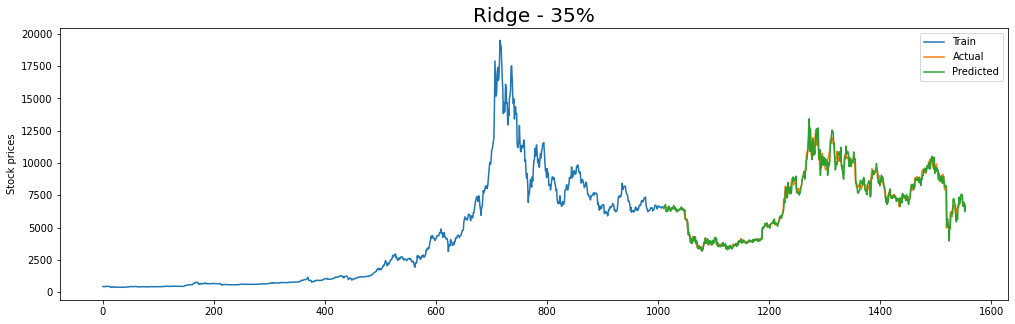

In [9]:
# ridge
trainx2_r, trainy2_r, testx2_r, testy2_r, prev_input2_r = data_gen(train_days2)
regr_train2 = evaluate_tick(regr, trainx2_r, trainy2_r, testx2_r, testy2_r)
regr_train2_shift = pd.Series(regr_train2[:],index=testy2_r.index)
plot_pred_tick(regr_train2_shift, 'Ridge - 35%', testy2_r, prev_input2_r)

Accuracy:  0.9786799841563855
MSE:  128711.76


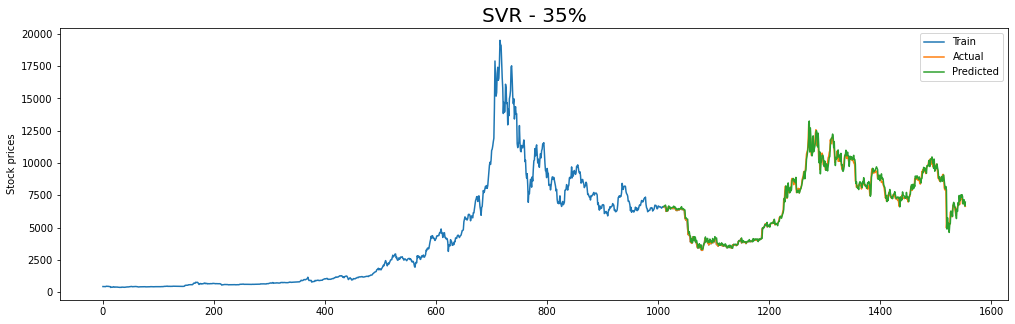

In [10]:
# svr
trainx2_s, trainy2_s, testx2_s, testy2_s, prev_input2_s = data_gen(train_days2)
regs_train2 = evaluate_tick(reg_svr, trainx2_s, trainy2_s, testx2_s, testy2_s)
regs_train2_shift = pd.Series(regs_train2[:],index=testy2_s.index)
plot_pred_tick(regs_train2_shift, 'SVR - 35%', testy2_s, prev_input2_s)

Accuracy:  0.8893087783285508
MSE:  535564.03


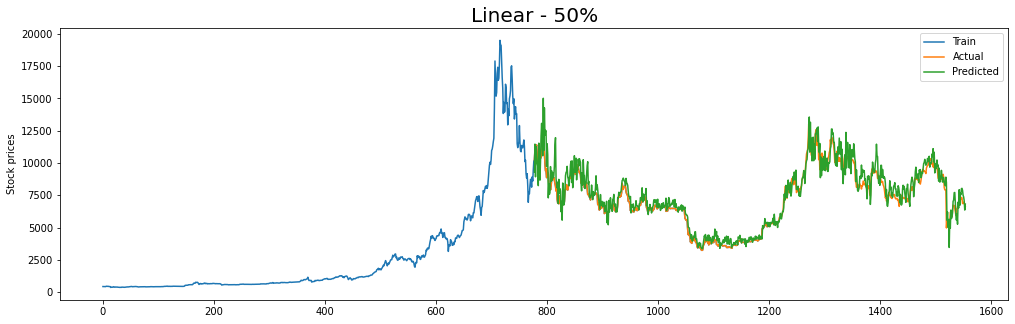

In [11]:
# for model series 3, 50% training
# linear
train_days3 = .5
trainx3_l, trainy3_l, testx3_l, testy3_l, prev_input3_l = data_gen(train_days3)
regl_train3 = evaluate_tick(regl, trainx3_l, trainy3_l, testx3_l, testy3_l)
regl_train3_shift = pd.Series(regl_train3[:],index=testy3_l.index)
plot_pred_tick(regl_train3_shift, 'Linear - 50%', testy3_l, prev_input3_l)

Accuracy:  0.8893135288934942
MSE:  535541.05


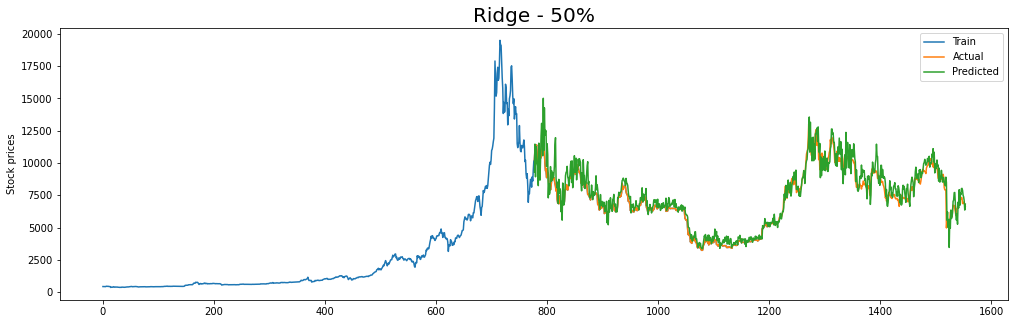

In [12]:
# ridge
trainx3_r, trainy3_r, testx3_r, testy3_r, prev_input3_r = data_gen(train_days3)
regr_train3 = evaluate_tick(regr, trainx3_r, trainy3_r, testx3_r, testy3_r)
regr_train3_shift = pd.Series(regr_train3[:],index=testy3_r.index)
plot_pred_tick(regr_train3_shift, 'Ridge - 50%', testy3_r, prev_input3_r)

Accuracy:  0.9463971066778535
MSE:  259350.12


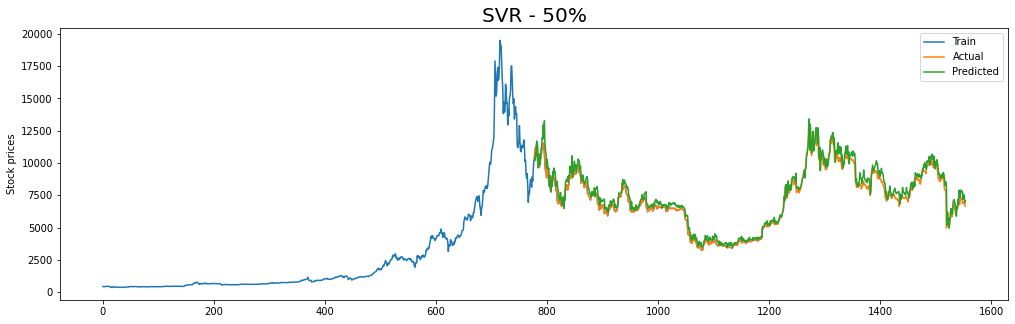

In [13]:
# svr
trainx3_s, trainy3_s, testx3_s, testy3_s, prev_input3_s = data_gen(train_days3)
regs_train3 = evaluate_tick(reg_svr, trainx3_s, trainy3_s, testx3_s, testy3_s)
regs_train3_shift = pd.Series(regs_train3[:],index=testy3_s.index)
plot_pred_tick(regs_train3_shift, 'SVR - 50%', testy3_s, prev_input3_s)

Ensemble

222948.60


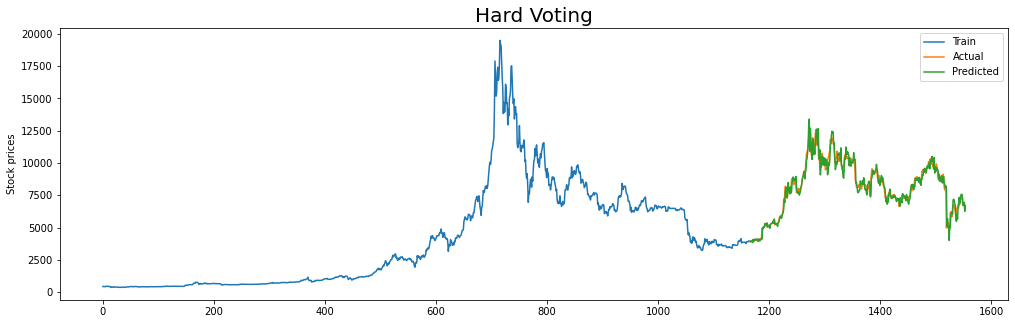

CPU times: user 112 ms, sys: 6.59 ms, total: 119 ms
Wall time: 113 ms


In [14]:

%%time
# hard voting
final_pred = np.array([])
for i in range(0,len(X_test3)):
    final_pred = np.append(final_pred, mode([
        regl_train[i], 
        regr_train[i], 
        regs_train[i],
        regl_train2[i],
        regr_train2[i],
        regs_train2[i],
        regl_train3[i],
        regr_train3[i],
        regs_train3[i],
    ]))
final_pred2 = pd.Series(final_pred[:],index=y_test3.index)
print("%.2f" % mse(final_pred2,y_test3))
plot_pred(final_pred2, 'Hard Voting')

4321435.88


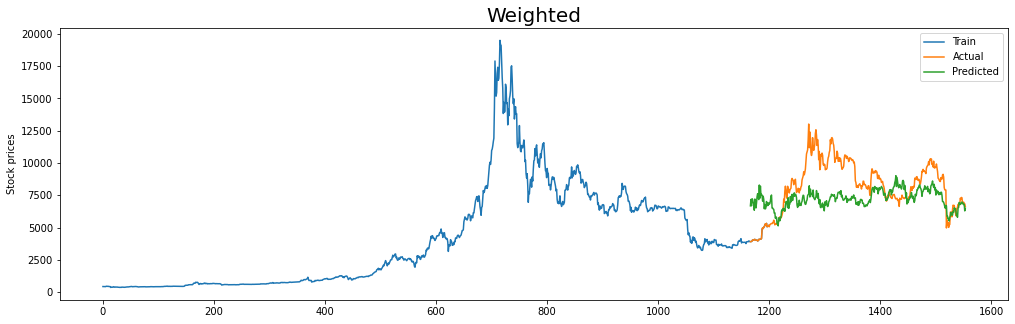

CPU times: user 108 ms, sys: 5.14 ms, total: 113 ms
Wall time: 111 ms


In [15]:
%%time
# weighted
final_pred_w = np.array([])
for i in range(0,len(X_test3)):
    final_pred_w = np.append(final_pred_w, (
        .111*regl_train[i] + 
        .111*regr_train[i] + 
        .111*regs_train[i] +
        .111*regl_train2[i] +
        .111*regr_train2[i] +
        .111*regs_train2[i] +
        .111*regl_train3[i] +
        .111*regr_train3[i] +
        .111*regs_train3[i]
    ))
final_pred_w2 = pd.Series(final_pred_w[:],index=y_test3.index)
print("%.2f" % mse(final_pred_w2,y_test3))
plot_pred(final_pred_w2, 'Weighted')

To summarize, we can see that the ensemble approaches did not improve upon the individual algorithms. That is to be expected, as we are only dragging the performance down with the inclusion of the less accurate models. To conclude, see below summary table of the nine models tested. Note the time for each was less than a second for each so to include is superfluous.

In [16]:
table_data=[
    ['Linear Regression - 25%', .25, 0.9677, 195745.43,],
    ['Ridge Regression - 25%', .25, 0.9677, 195744.89],
    ['Linear SVR - 25%', .25, 0.9370, 382764.17],
    ['Linear Regression - 35%',.35, 0.9710, 174824.90],
    ['Ridge Regression - 35%',.35, 0.9710, 174824.38],
    ['Linear SVR - 35%',.35, 0.9788, 127628.45],
    ['Linear Regression - 50%',.5, 0.8893, 535564.03],
    ['Ridge Regression - 50%',.5, 0.8893, 535541.05],
    ['Linear SVR - 50%', .5,0.9169, 401630.79],

]
df_table = pd.DataFrame(table_data)
# sort table in descending order by accuracy
df_table = df_table.sort_values(by=[3], kind="quicksort", ascending=True)
df_table[1] = pd.Series(["{0:.1f}%".format(val * 100) for val in df_table[1]], index = df_table.index)
df_table[2] = pd.Series(["{0:.1f}%".format(val * 100) for val in df_table[2]], index = df_table.index)
fig = go.Figure(data=[go.Table(header=dict(values=['Method','Test %', 'Accuracy','MSE']),
                 cells=dict(values=[df_table[0], df_table[1], df_table[2], df_table[3]]))
                     ])
fig.show()

# 2. Feature Selection

This dataset is sort of strange in that it appears to have many useful features, but in reality that is not the case. As we will see, there are only really three useful features for predicting price. However even with these three features, the price prediction is very poor when compared to a regression analysis.

Due to the continuous nature of the target variable, price_usd, regression is of course a more suitable approach. I believe the results of Question 1 are very telling of that, and am I pleased with their results.

On the other hand, when examing the features through a formulaic lense, the results were surprising in their own right. First, I ran a PCA analysis to see how many of the features would be helpful. Here is where we can clearly see how irrelevant most of the features are. In looking at the 'PCA Analysis' graph below, we see an unusual shape. Mathematically, three variables account for over 90% of the variance. This makes it hard for algorithms to make classification judgments as there is just not a lot to draw from.

Second, I ran a feature importance check using a derivative of gradient boosting to support my PCA analysis. The three variables which account for the 90% variance are shown. I also did a partial plot, but it doesn't really tell us anything new.

Finally, I used gradient boosting again but this time to predict the data. I graphed the results using just the three main features to train on. Then I trained a second model on all available features that weren't redundant. Here, while we see an improvement (which is expected as we are including more attributes), the improvement is very minimal. The results between these two were so close, because really only those three variables are driving the prediction. Just to add some variety, I ran a third with a couple of the features that weren't useful at all.

Usually at these steps, I would be trying to optimize feature selection and create the best possible combination. In this case, there just isn't the need. I am finishing this question with an ensemble approach in order to demonstrate how to put one together. Unfortunately, because of the lack of features, I am deliberately making the accuracy worse by incorporating that third model. 

I still believe it to be a good exercise in showing: how to examine the features, determine their relevance, construct multiple models, and finally sythesize them with an ensemble approach.

In [17]:
btc_data = df[df['ticker']=='BTC']

In [18]:
final_vars = ['volume', 'market_cap', 'capitalization_change_1_day', 'max_supply', 'minable']
train_y = btc_data.price_usd.values
train_X = btc_data[final_vars]
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
dmodel = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=100)
remain_num = 99

In [31]:
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
pca_check = btc_data.select_dtypes(exclude="object").values
pca_check = scale(pca_check);pca_check
covar = PCA(n_components = 5)
covar.fit(pca_check)
var = covar.explained_variance_ratio_
var=np.cumsum(np.round(covar.explained_variance_ratio_, decimals=5)*100)
print(var)

[ 42.219  75.55   92.195  99.991 100.001]


In [32]:
result = np.where(var>=90)
print(result[0][0])

2


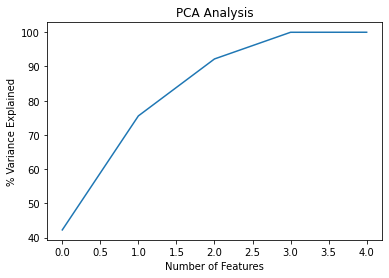

In [33]:
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.plot(var)

I came across a package known as XGBoost, which is sort of a "pre-optimized" gradient boosting method. While there are still parameters to train, the core algorithm already comes ready to run. Additionally, there are more functions built around it, and one in particular (DMatrix) is very useful for selecting feature importance. It is also specifically built for numerical data, and as the target attribute is numeric, this approach is very appropriate.

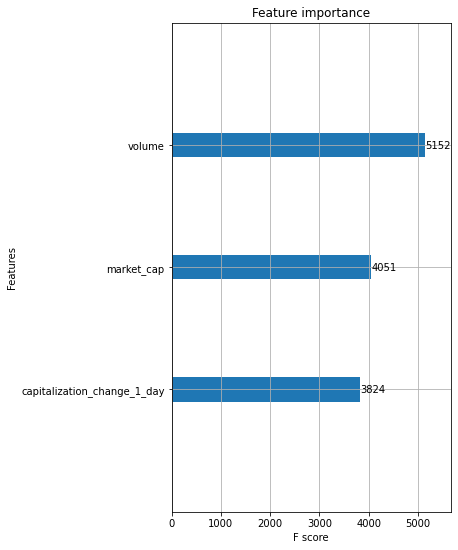

In [22]:
fig, ax = plt.subplots(figsize=(5,9))
xgb.plot_importance(dmodel, max_num_features=remain_num, height=0.2, ax=ax)
plt.show()

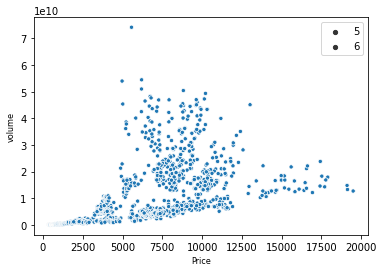

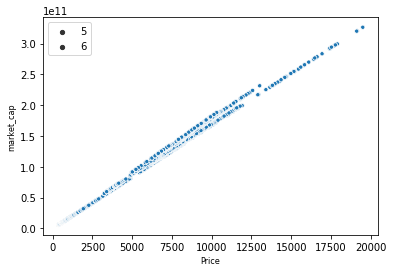

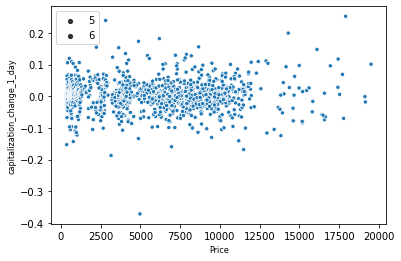

In [23]:
xgb_vars = ['volume', 'market_cap', 'capitalization_change_1_day']
for f in [x for x in xgb_vars]:
    sns.scatterplot(y=btc_data[f].values, x=btc_data.price_usd.values, size=6)
    plt.xlabel('Price', fontsize=8)
    plt.ylabel(f, fontsize=8)
    plt.show()

For additional support, the sugested partial plots of the three most important features. Note that I used a generic gradient boosting model simply to help visualize. However I believe this method was not as helpful as the above scatter plots. 

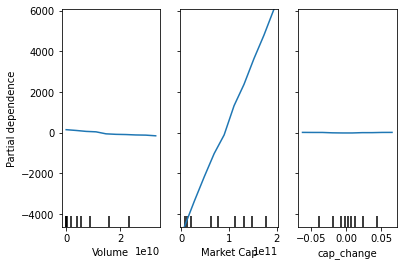

In [24]:
y = btc_data.price_usd
X = btc_data[xgb_vars]
gmodel = GradientBoostingRegressor()
gmodel.fit(X, y)
plots = plot_partial_dependence(gmodel,       
                                   features=[0, 1, 2], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names=['Volume', 'Market Cap', 'cap_change'], # labels on graphs
                                   grid_resolution=10,
                                   target='price_usd') # number of values to plot on x axis

In [25]:
# Model 1: using the xgb_vars found above
# This is the "best" model and truly the optimal result of the previous analysis

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2998, random_state=61)
gfit = gmodel.fit(X_train, y_train)
gpred = gfit.predict(X_test)
gpred_shift = pd.Series(gpred[:],index=y_test.index)

#print('Accuracy: ', out_mod1.score(pd.DataFrame(y_pred_dt).to_numpy(), y_test2))
print('MSE: ',"%.2f" % mse(gpred,y_test))
print('MAE: ',"%.2f" % mae(gpred,y_test))

fig1 = go.Figure()
fig1.add_trace(go.Scatter(y=btc_data.iloc[btc_data.shape[0]-100:]['price_usd'], name='Real price'))
fig1.add_trace(go.Scatter(y=gpred_shift[-100:], name='Predict price'))
fig1.show()

MSE:  8863.40
MAE:  54.30


In [26]:
# Model 2: using all the relevant variables
mod2_vars = ['volume', 'price_usd', 'price_btc', 'market_cap', 'capitalization_change_1_day',
            'USD_price_change_1_day', 'BTC_price_change_1_day', 'max_supply', 'minable']
X2 = btc_data[mod2_vars]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y, test_size=.2998, random_state=61)
gfit2 = gmodel.fit(X_train2, y_train2)
gpred2 = gfit2.predict(X_test2)
gpred2_shift = pd.Series(gpred2[:],index=y_test2.index)

#print('Accuracy: ', out_mod1.score(pd.DataFrame(y_pred_dt).to_numpy(), y_test2))
print('MSE: ',"%.2f" % mse(gpred2,y_test2))
print('MAE: ',"%.2f" % mae(gpred2,y_test2))

fig2 = go.Figure()
fig2.add_trace(go.Scatter(y=btc_data.iloc[btc_data.shape[0]-100:]['price_usd'], name='Real price'))
fig2.add_trace(go.Scatter(y=gpred2_shift[-100:], name='Prediction - All'))
fig2.show()

MSE:  2494.82
MAE:  25.78


In [27]:
# Model 3: using irrelvant/poor attributes
mod3_vars = ['max_supply', 'minable', 'USD_price_change_1_day']
X3 = btc_data[mod3_vars]
X_trainM, X_testM, y_trainM, y_testM = train_test_split(X3, y, test_size=.2998, random_state=61)
gfit3 = gmodel.fit(X_trainM, y_trainM)
gpred3 = gfit3.predict(X_testM)
gpred3_shift = pd.Series(gpred3[:],index=y_testM.index)

#print('Accuracy: ', out_mod1.score(pd.DataFrame(y_pred_dt).to_numpy(), y_test2))
print('MSE: ',"%.2f" % mse(gpred3,y_testM))
print('MAE: ',"%.2f" % mae(gpred3,y_testM))

fig2 = go.Figure()
fig2.add_trace(go.Scatter(y=btc_data.iloc[btc_data.shape[0]-100:]['price_usd'], name='Real price'))
fig2.add_trace(go.Scatter(y=gpred3_shift[-100:], name='Prediction - Poor'))
fig2.show()

MSE:  15483777.57
MAE:  3401.44


Now in order to complete the exercise, two examples of the ensemble method. One using hard voting, where I will be manually taking the mode for each day. Next, I will manually assign weights to each model's price for a given day. Note the strong improvement in switching to weightings vs. hard voting. Also note how poorly both options perform in comparision to models 1 and 2 above. Again, this is because I added model 3 for demonstrative purposes.

Finally, in comparison to the regression analysis, I understand these graphs are almost laughable by comparison. However I still believe the exercise to be a success. It is much harder to try and predict a price by these anciliary characteristics as compared to actual pricing data and algorithms specifically for that purpose. So a good learning experience, and one that is aided by these poorly fitted graphs. The point was to show how feature selection can enhance or detract from a model's performance, which I think this does well. Had I been going for just performance, I would stick to regression.

29726093.51
MAE:  4461.30


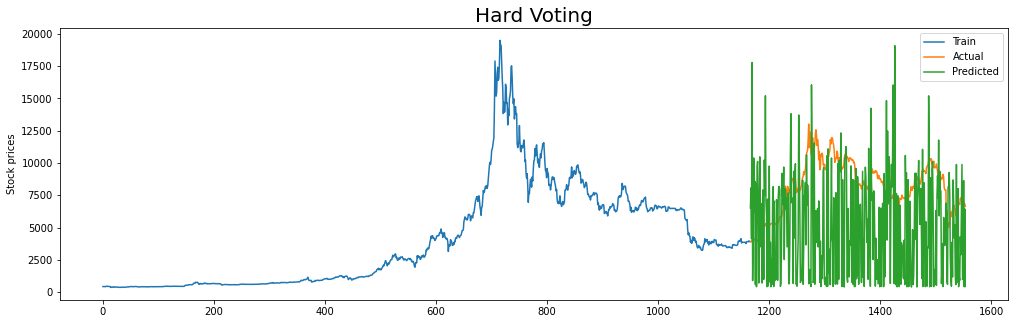

CPU times: user 122 ms, sys: 4.11 ms, total: 126 ms
Wall time: 122 ms


In [28]:
%%time
# hard voting
final_pred = np.array([])
for i in range(0,len(X_test3)):
    final_pred = np.append(final_pred, mode([gpred[i], gpred2[i], gpred3[i]]))
final_pred2 = pd.Series(final_pred[:],index=y_test3.index)
print("%.2f" % mse(final_pred2,y_test3))
print('MAE: ',"%.2f" % mae(final_pred2,y_test3))
plot_pred(final_pred2, 'Hard Voting')

21622364.98
MAE:  3895.05


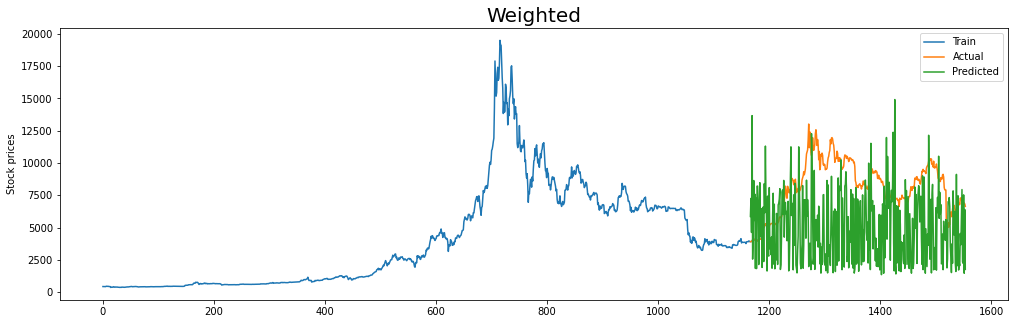

CPU times: user 121 ms, sys: 1.39 ms, total: 123 ms
Wall time: 118 ms


In [29]:
%%time
# weighted
final_pred_w = np.array([])
for i in range(0,len(X_test3)):
    final_pred_w = np.append(final_pred_w, (.33*gpred[i] + .33*gpred2[i] + .33*gpred3[i]))
final_pred_w2 = pd.Series(final_pred_w[:],index=y_test3.index)
print("%.2f" % mse(final_pred_w2,y_test3))
print('MAE: ',"%.2f" % mae(final_pred_w2,y_test3))
plot_pred(final_pred_w2, 'Weighted')

Quick summary table below, we can see that based on MSE model 2, with all relevant features, performed the best. The inclusion of the "dummy" model 3 really brings down the accuracy of the ensemble approaches, in fact confusing them even more than on its own. Again, time to train is all less than a second so irrelevant.

In [30]:
table_data2=[
    ['Model 1', 'Top 3 Features', 8876.25, 54.49,],
    ['Model 2', 'All Relevant Features', 2503.04, 25.91],
    ['Model 3', 'Irrelevant/Poor Features', 15483777.57, 3401.44],
    ['Ensemble 1','Hard Voting', 28019704.97, 4441.12],
    ['Ensemble 2','Weighted', 19740732.54, 3708.91],

]
df_table2 = pd.DataFrame(table_data2)
# sort table in descending order by accuracy
df_table2 = df_table2.sort_values(by=[2], kind="quicksort", ascending=True)
fig2 = go.Figure(data=[go.Table(header=dict(values=['Method','Features', 'MSE','MAE']),
                 cells=dict(values=[df_table2[0], df_table2[1], df_table2[2], df_table2[3]]))
                     ])
fig2.show()